### Summary of Akshita's Setup
- **Step 1**: Map compute (N, D) to task loss (bpb on CF continuation). *Only the final checkpoints are used*
- **Step 2**: Map task loss (bpb on CF) to task score (accuracy) using sigmoid.

Additional hacks:
1. **2 additional points**: Additional points added for perfect score (bpb=0.01, accuracy=1) and random chance (bpb=2.6, accuracy=0.25). bpb=2.6 is arbitrarily chosen
2. **Moving average**: Use moving average with window size = 20. 20 is arbitrarily chosen
3. **Expontential moving average**: Use EMA with alpha=0.5
4. **Last n% of points**: Instead of all bpb, only use the last 2% of points per run. 2% is arbitrary.

Notes:
- BoolQ is removed from aggregate scores due to noise

Experimental settings:
- **Easy**: Use every model up to the target model
- **Hard**: Use models with 1/10th the training tokens of the target model

In [1]:
%load_ext autoreload
%autoreload 2

### Setup (Pull W&B Logs)

In [2]:
from olmo.scaling.scaling_laws.download_wandb_logs import main as download_wb
from a_david_noise_utils import get_name_size_length
from argparse import Namespace
import os
import itertools

WANDB_RESULTS = "wandb/peteish-final-backfill3"
FIGURES = "figures"

run_names = [
    f"ai2-llm/olmo-ladder/peteish-final-{size}-{length}-backfill3"
    for size, length in itertools.product(["190M", "370M", "600M", "760M", "1B"], ["1xC", "2xC", "5xC", "10xC"])
]

validation_outputs = {}
for run_name in run_names:
    if "peteish7" in run_name:
        output_name = "peteish7"
    else:
        output_name = run_name.split("/")[-1]
        name, size, length = get_name_size_length(run_name.removesuffix("-backfill3"))
        output_name = f"{size}-{length}"
    output_path = f"{WANDB_RESULTS}/{output_name}.csv"
    args = Namespace(
        wandb_names=[run_name],
        x_axis="_step",
        y_axis=["eval/validation-and-bpb-and-downstream"],
        output_path=output_path,
        eval_only=True
    )
    if not os.path.exists(output_path):
        download_wb(args)
    validation_outputs[output_name] = output_path

/Users/dhei/miniconda3/envs/olmo/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from olmo.scaling.scaling_laws.download_wandb_logs import main as download_wb
from a_david_noise_utils import get_name_size_length
from argparse import Namespace
import os
import itertools

WANDB_RESULTS = "wandb/peteish-final-backfill3"
FIGURES = "figures"

run_names = [
    f"ai2-llm/olmo-ladder/peteish-final-{size}-{length}"
    for size, length in itertools.product(["190M", "370M", "600M", "760M", "1B"], ["1xC", "2xC", "5xC", "10xC"])
]

validation_outputs = {}
for run_name in run_names:
    if "peteish7" in run_name:
        output_name = "peteish7"
    else:
        output_name = run_name.split("/")[-1]
        name, size, length = get_name_size_length(run_name)
        output_name = f"{size}-{length}"
    output_path = f"{WANDB_RESULTS}/{output_name}.csv"
    args = Namespace(
        wandb_names=[run_name],
        # x_axis="throughput/total_tokens",
        x_axis="_step",
        y_axis=["eval/validation-and-bpb-and-downstream"],
        output_path=output_path,
        eval_only=False
    )
    if not os.path.exists(output_path):
        download_wb(args)
    validation_outputs[output_name] = output_path

### Hard Setting

In [4]:
import ladder_peteish as ladder

# Find the model size corresponding to 10x less compute
all_flops = []
for size in ["190M", "370M", "600M", "760M", "1B"]:
    paths = []
    for length in ["1xC", "2xC", "5xC", "10xC"]:
        if size == "3B" and length == "10xC":
            break
        model_flops = ladder.MODEL_GFLOPS[size]
        length_in_tokens = ladder.parse_length(length, ladder.parse_size(size))
        total_flops = (model_flops * length_in_tokens) / 1e18
        all_flops.append((f"{size}-{length}", total_flops))
sorted_by_flops = sorted(all_flops, key=lambda x:x[1])
corresponding_flops_10x = {
    "1B-10xC": "1B-1xC",
}

# for tup in sorted_by_flops:
#     print(tup)
# print("Using generous upper-bounds to find nearest corresponding 10x less flops run")
# for key, val in corresponding_flops_10x.items():
#     print(f"{key} uses upto {val}")

In [5]:
from a_david_noise_utils import COLOR_MAP, N_LAST_CKPTS
from olmo.scaling.scaling_laws.utils import FinalConfig

all_configs = []

for run_name, max_train_run in corresponding_flops_10x.items():
    configs_size = {}
    for (train_run, _) in sorted_by_flops:
        
        train_size, train_length = train_run.split("-")
        if train_size in configs_size:
            configs_size[train_size]["paths"].append(f"{WANDB_RESULTS}/{train_run}.csv")
        else:
            configs_size[train_size] = {
                "paths": [f"{WANDB_RESULTS}/{train_run}.csv"],
                "mode": "train",
                "n": ladder.MODEL_PARAMS[train_size],
                "label": train_size,
                "color": COLOR_MAP[train_size]
            }

        if train_run == max_train_run:
            break

    size, length = run_name.split("-")
    configs_size[f"{size}-{length}"] = {
        "paths": [f"{WANDB_RESULTS}/{run_name}.csv"],
        "mode": "eval",
        "n": ladder.MODEL_PARAMS[size],
        "label": size,
        "color": COLOR_MAP[size]
    }
    configs_size = {name: FinalConfig(**config) for name, config in configs_size.items()}
    all_configs.append(configs_size)

### Predictions using Soft Accuracy

See [Alex's writeup](https://docs.google.com/document/d/1FRGOltRRWbI3vunwpBCvv4-KLYzNwqvSO0AiwBpKw3k/edit?tab=t.0)

Use the probability of choice i:

> P_task(choice_i) = softmax(log p(y_i | x) / normalization)

Final (step 2) accuracy defined as:

> Accuracy = Mean(1[argmax_i P_task(choice_i) = label ])

Initial (step 1) task loss defined by the probability of the choices:

> TaskCrossEntropy = Mean( -log P_task(label) )

In [6]:
del all_configs[0]["1B"]

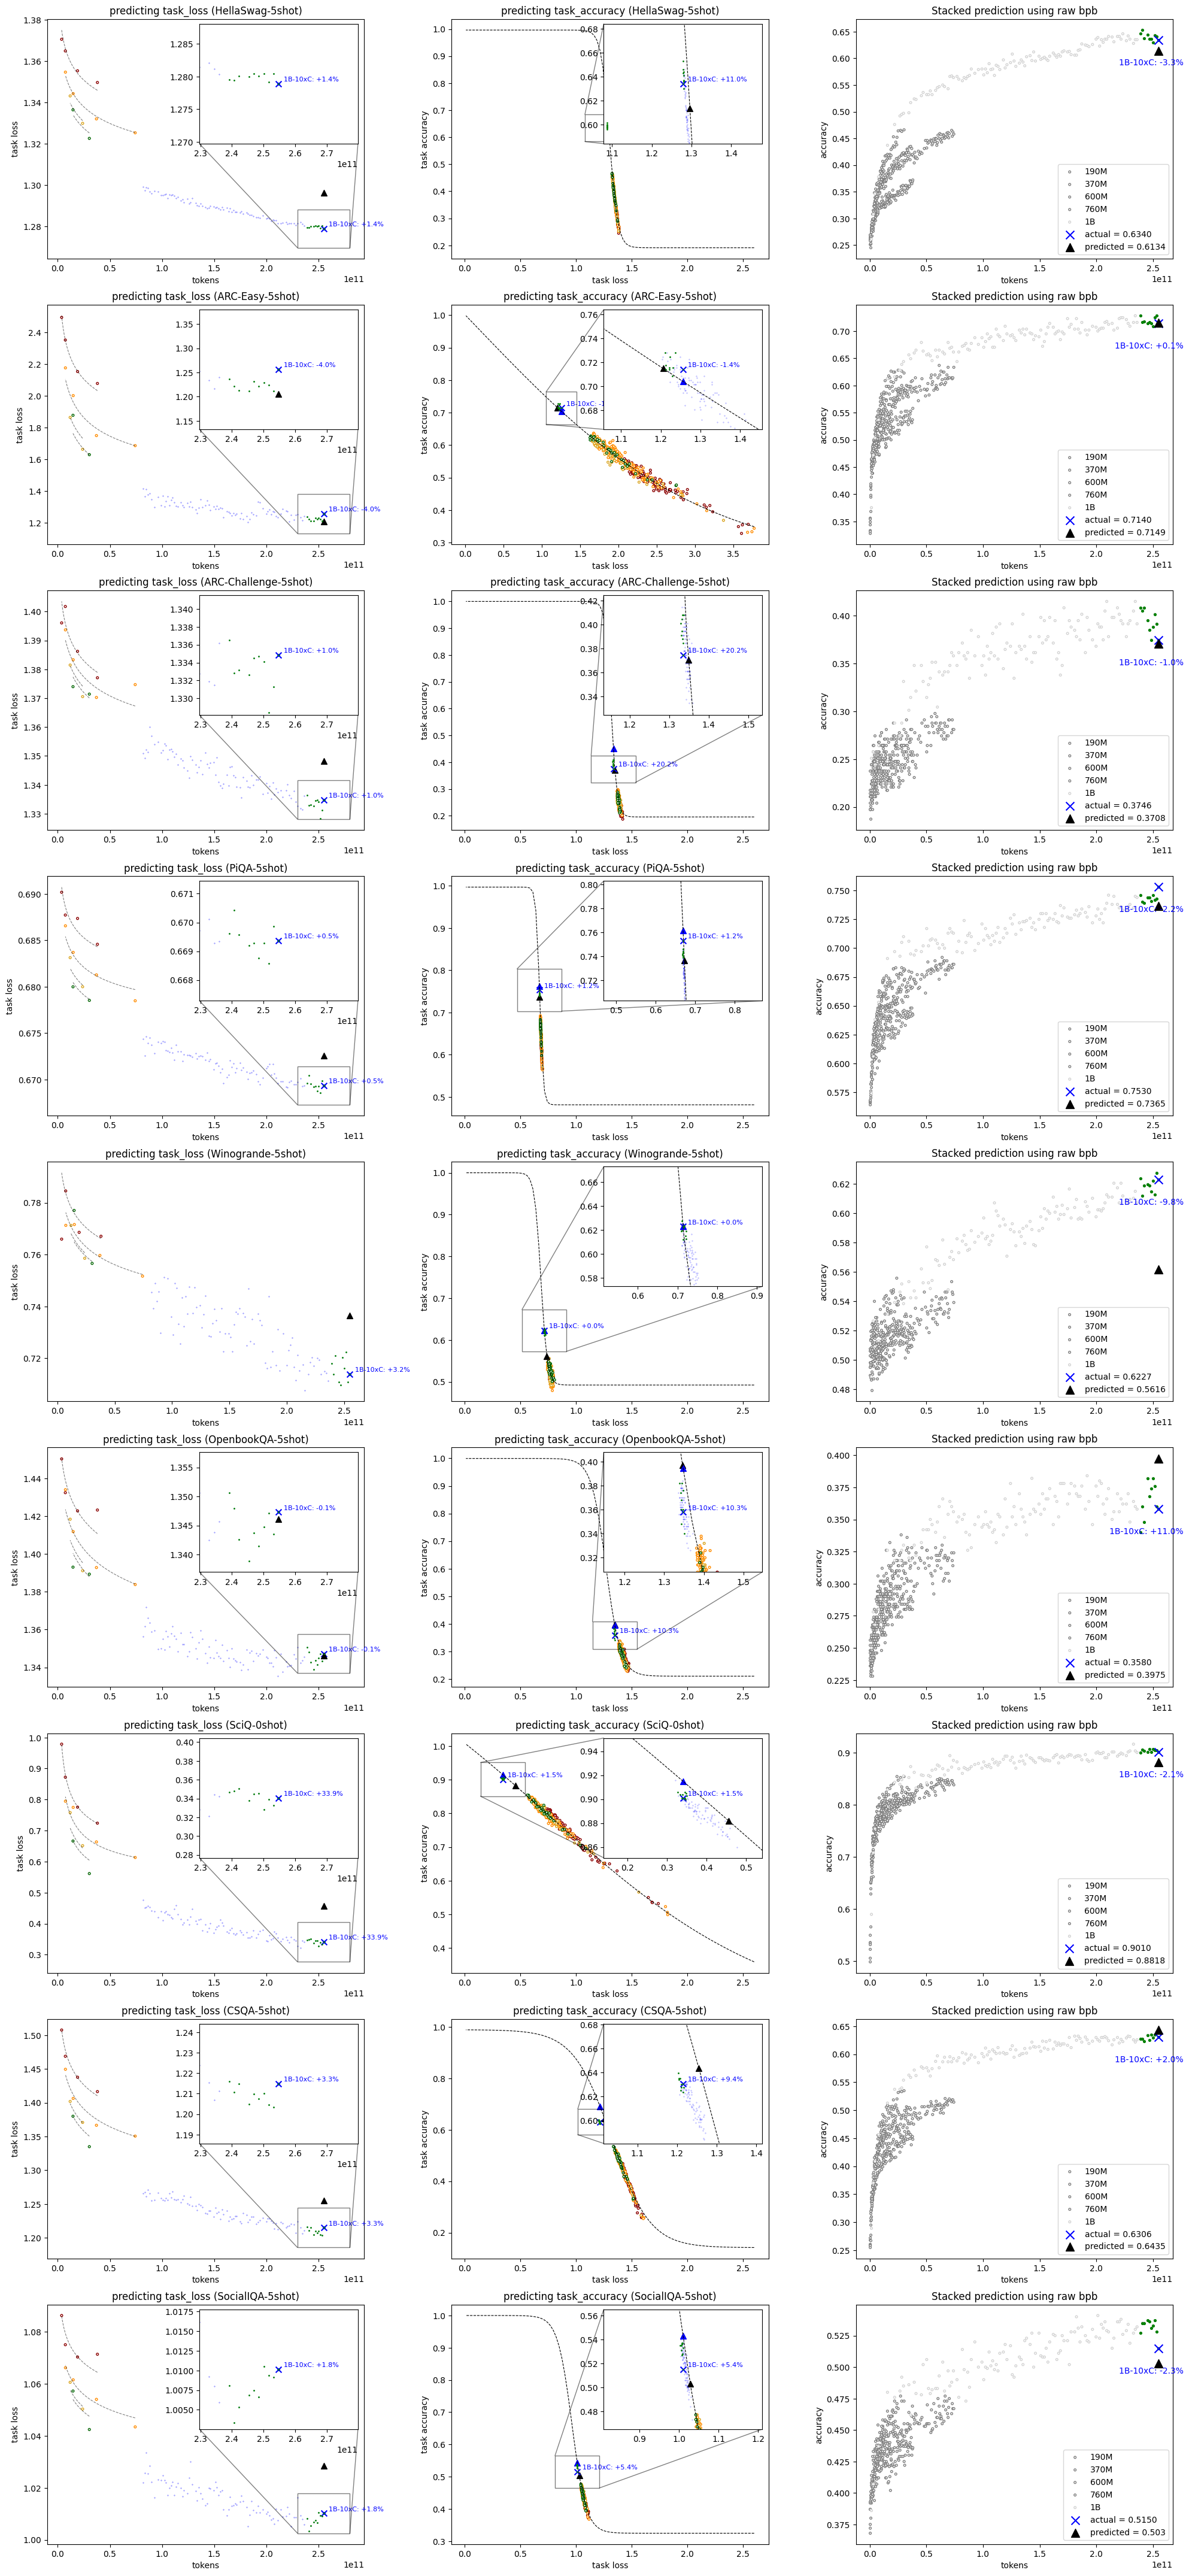

In [7]:
from a_david_noise_utils import run_stacked, SOFT_TASKS

step1_error, step2_error, stacked_error = run_stacked(all_configs, tasks=SOFT_TASKS)

In [8]:
print('Errors for the prediction target (blue X)')
print('Note: "Step 2 ONLY" means that we use the gold task loss to predict the task accuracy, so this shows the error of step 2 if the step 1 predictions are perfect.')
from a_david_noise_utils import print_step_error_table
print_step_error_table(step1_error, step2_error, stacked_error)

Errors for the prediction target (blue X)
Note: "Step 2 ONLY" means that we use the gold task loss to predict the task accuracy, so this shows the error of step 2 if the step 1 predictions are perfect.


| Task | Step 1 error (1B-10xC) |Step 2 error (1B-10xC) |Stacked error (1B-10xC) |
| --- | --- | --- | --- |
| HellaSwag-5shot | +1.4% | +11.0% | -3.3% |
| ARC-Easy-5shot | -4.0% | -1.4% | +0.1% |
| ARC-Challenge-5shot | +1.0% | +20.2% | -1.0% |
| PiQA-5shot | +0.5% | +1.2% | -2.2% |
| Winogrande-5shot | +3.2% | +0.0% | -9.8% |
| OpenbookQA-5shot | -0.1% | +10.3% | +11.0% |
| SciQ-0shot | +33.9% | +1.5% | -2.1% |
| CSQA-5shot | +3.3% | +9.4% | +2.0% |
| SocialIQA-5shot | +1.8% | +5.4% | -2.3% |
| **Avg unsigned stacked error** (excl. BoolQ, MMLU subsets) | **+5.5%** |**+6.7%** |**+3.8%** |

In [9]:
from IPython.display import display, Markdown
from a_david_noise_utils import TASKS_REORDERED
print(f'Coefficient of variation of the last {N_LAST_CKPTS} prediction targets:')
display(Markdown(r'$$\text{CV} = \frac{\sigma}{\bar{x}}$$'))
step1_error, step2_error, stacked_error = run_stacked(all_configs, render_plot=False, tasks=SOFT_TASKS)
print_step_error_table(step1_error=step1_error, stacked_error=stacked_error, entry_value='y_lastn_coeff_var')

Coefficient of variation of the last 10 prediction targets:


$$\text{CV} = \frac{\sigma}{\bar{x}}$$

| Task | Target task loss coefficient of variation (1B-10xC) |Target accuracy coefficient of variation (1B-10xC) |
| --- | --- | --- |
| HellaSwag-5shot | 0.04% | 1.00% |
| ARC-Easy-5shot | 1.06% | 0.87% |
| ARC-Challenge-5shot | 0.16% | 3.05% |
| PiQA-5shot | 0.08% | 0.51% |
| Winogrande-5shot | 0.61% | 0.77% |
| OpenbookQA-5shot | 0.25% | 3.68% |
| SciQ-0shot | 1.98% | 0.23% |
| CSQA-5shot | 0.36% | 0.77% |
| SocialIQA-5shot | 0.21% | 1.21% |
| **Avg unsigned target accuracy coefficient of variation** (excl. BoolQ, MMLU subsets) | **0.53%** |**1.34%** |

In [10]:
print(f'Number of standard deviations for the prediction target from the mean (z-score) of last {N_LAST_CKPTS} prediction target ckpts:')
print_step_error_table(step1_error=step1_error, stacked_error=stacked_error, entry_value='y_lastn_z_score')

Number of standard deviations for the prediction target from the mean (z-score) of last 10 prediction target ckpts:


| Task | Target task loss z-score (1B-10xC) |Target accuracy z-score (1B-10xC) |
| --- | --- | --- |
| HellaSwag-5shot | 30.4 | -4.2 |
| ARC-Easy-5shot | -1.5 | -0.5 |
| ARC-Challenge-5shot | 7.0 | -1.9 |
| PiQA-5shot | 6.2 | -1.9 |
| Winogrande-5shot | 4.8 | -12.1 |
| OpenbookQA-5shot | 0.4 | 2.4 |
| SciQ-0shot | 17.0 | -10.1 |
| CSQA-5shot | 10.3 | 2.7 |
| SocialIQA-5shot | 9.8 | -4.4 |
| **Avg unsigned target accuracy z-score** (excl. BoolQ, MMLU subsets) | **9.7** |**4.5** |

In [11]:
# Test out tricks to improve fit
print(f"Original setup (error on avg. of last {N_LAST_CKPTS} prediction checkpoints):")

step1_error, step2_error, stacked_error = run_stacked(all_configs, tasks=SOFT_TASKS, render_plot=False)
print_step_error_table(step1_error, step2_error, stacked_error, entry_value='rel_error_lastn_mean')

print(f"Original setup + Only use last 2% of checkpoints (error on avg. of last {N_LAST_CKPTS} prediction checkpoints):")

step1_error, step2_error, stacked_error = run_stacked(all_configs, tasks=SOFT_TASKS, limit_ckpts='last_n', render_plot=False)
print_step_error_table(step1_error, step2_error, stacked_error, entry_value='rel_error_lastn_mean')

print(f"Original setup + EMA (error on avg. of last {N_LAST_CKPTS} prediction checkpoints):")

step1_error, step2_error, stacked_error = run_stacked(all_configs, tasks=SOFT_TASKS, smoothing='ema', render_plot=False)
print_step_error_table(step1_error, step2_error, stacked_error, entry_value='rel_error_lastn_mean')

print(f"Original setup + EMA + Only use last 2% of checkpoints (error on avg. of last {N_LAST_CKPTS} prediction checkpoints):")

step1_error, step2_error, stacked_error = run_stacked(all_configs, tasks=SOFT_TASKS, smoothing='ema', limit_ckpts='last_n', render_plot=False)
print_step_error_table(step1_error, step2_error, stacked_error, entry_value='rel_error_lastn_mean')

print(f"Original setup + Only use last checkpoint (error on avg. of last {N_LAST_CKPTS} prediction checkpoints):")

step1_error, step2_error, stacked_error = run_stacked(all_configs, tasks=SOFT_TASKS, limit_ckpts='final', render_plot=False)
print_step_error_table(step1_error, step2_error, stacked_error, entry_value='rel_error_lastn_mean')

Original setup (error on avg. of last 10 prediction checkpoints):


| Task | Step 1 error (1B-10xC) |Step 2 error (1B-10xC) |Stacked error (1B-10xC) |
| --- | --- | --- | --- |
| HellaSwag-5shot | +1.3% | +10.0% | -4.2% |
| ARC-Easy-5shot | -1.6% | -1.9% | -0.4% |
| ARC-Challenge-5shot | +1.1% | +14.6% | -5.7% |
| PiQA-5shot | +0.5% | +2.4% | -1.0% |
| Winogrande-5shot | +2.9% | +0.6% | -9.3% |
| OpenbookQA-5shot | +0.1% | +8.3% | +9.0% |
| SciQ-0shot | +33.6% | +1.3% | -2.4% |
| CSQA-5shot | +3.7% | +9.4% | +2.0% |
| SocialIQA-5shot | +2.1% | +2.2% | -5.3% |
| **Avg unsigned stacked error** (excl. BoolQ, MMLU subsets) | **+5.2%** |**+5.6%** |**+4.4%** |

Original setup + Only use last 2% of checkpoints (error on avg. of last 10 prediction checkpoints):


| Task | Step 1 error (1B-10xC) |Step 2 error (1B-10xC) |Stacked error (1B-10xC) |
| --- | --- | --- | --- |
| HellaSwag-5shot | +1.3% | +14.8% | -1.7% |
| ARC-Easy-5shot | -1.6% | -2.7% | -1.2% |
| ARC-Challenge-5shot | +1.1% | +76.6% | +22.1% |
| PiQA-5shot | +0.5% | +1.4% | -1.8% |
| Winogrande-5shot | +2.9% | +7.6% | -7.1% |
| OpenbookQA-5shot | +0.1% | +12.5% | +13.4% |
| SciQ-0shot | +33.6% | +1.4% | -2.0% |
| CSQA-5shot | +3.7% | +8.7% | +1.1% |
| SocialIQA-5shot | +2.1% | +0.2% | -6.5% |
| **Avg unsigned stacked error** (excl. BoolQ, MMLU subsets) | **+5.2%** |**+14.0%** |**+6.3%** |

Original setup + EMA (error on avg. of last 10 prediction checkpoints):


| Task | Step 1 error (1B-10xC) |Step 2 error (1B-10xC) |Stacked error (1B-10xC) |
| --- | --- | --- | --- |
| HellaSwag-5shot | +1.2% | +8.9% | -3.0% |
| ARC-Easy-5shot | -0.5% | -1.8% | -1.3% |
| ARC-Challenge-5shot | +1.2% | +22.1% | -4.1% |
| PiQA-5shot | +0.4% | +2.3% | -0.9% |
| Winogrande-5shot | +2.7% | +2.1% | -7.8% |
| OpenbookQA-5shot | +0.1% | +9.2% | +9.0% |
| SciQ-0shot | +26.6% | +0.3% | -2.4% |
| CSQA-5shot | +5.8% | +9.4% | -3.0% |
| SocialIQA-5shot | +1.9% | +2.1% | -4.9% |
| **Avg unsigned stacked error** (excl. BoolQ, MMLU subsets) | **+4.5%** |**+6.5%** |**+4.0%** |

Original setup + EMA + Only use last 2% of checkpoints (error on avg. of last 10 prediction checkpoints):


| Task | Step 1 error (1B-10xC) |Step 2 error (1B-10xC) |Stacked error (1B-10xC) |
| --- | --- | --- | --- |
| HellaSwag-5shot | +1.2% | +13.7% | -0.3% |
| ARC-Easy-5shot | -0.5% | -2.2% | -1.7% |
| ARC-Challenge-5shot | +1.2% | +74.0% | +15.8% |
| PiQA-5shot | +0.4% | +1.4% | -1.6% |
| Winogrande-5shot | +2.7% | +10.7% | -5.1% |
| OpenbookQA-5shot | +0.1% | +13.9% | +13.6% |
| SciQ-0shot | +26.6% | +1.3% | -1.4% |
| CSQA-5shot | +5.8% | +9.5% | -3.5% |
| SocialIQA-5shot | +1.9% | +0.8% | -5.7% |
| **Avg unsigned stacked error** (excl. BoolQ, MMLU subsets) | **+4.5%** |**+14.2%** |**+5.4%** |

Original setup + Only use last checkpoint (error on avg. of last 10 prediction checkpoints):


| Task | Step 1 error (1B-10xC) |Step 2 error (1B-10xC) |Stacked error (1B-10xC) |
| --- | --- | --- | --- |
| HellaSwag-5shot | +1.3% | +4.4% | +4.1% |
| ARC-Easy-5shot | -1.6% | -3.8% | +1.7% |
| ARC-Challenge-5shot | +1.1% | +89.7% | +97.6% |
| PiQA-5shot | +0.5% | +0.3% | +1.1% |
| Winogrande-5shot | +2.9% | -2.0% | +0.2% |
| OpenbookQA-5shot | +0.1% | +4.3% | +10.5% |
| SciQ-0shot | +33.6% | -2.5% | -3.0% |
| CSQA-5shot | +3.7% | +2.6% | +3.5% |
| SocialIQA-5shot | +2.1% | -4.0% | -6.2% |
| **Avg unsigned stacked error** (excl. BoolQ, MMLU subsets) | **+5.2%** |**+12.6%** |**+14.2%** |

In [12]:
print(f'Errors when averaging the prediction target over the last {N_LAST_CKPTS} checkpoints (using the green X instead of the blue X):')
step1_error, step2_error, stacked_error = run_stacked(all_configs, tasks=SOFT_TASKS, render_plot=False)
print_step_error_table(step1_error, step2_error, stacked_error, entry_value='rel_error_lastn_mean')

Errors when averaging the prediction target over the last 10 checkpoints (using the green X instead of the blue X):


| Task | Step 1 error (1B-10xC) |Step 2 error (1B-10xC) |Stacked error (1B-10xC) |
| --- | --- | --- | --- |
| HellaSwag-5shot | +1.3% | +10.0% | -4.2% |
| ARC-Easy-5shot | -1.6% | -1.9% | -0.4% |
| ARC-Challenge-5shot | +1.1% | +14.6% | -5.7% |
| PiQA-5shot | +0.5% | +2.4% | -1.0% |
| Winogrande-5shot | +2.9% | +0.6% | -9.3% |
| OpenbookQA-5shot | +0.1% | +8.3% | +9.0% |
| SciQ-0shot | +33.6% | +1.3% | -2.4% |
| CSQA-5shot | +3.7% | +9.4% | +2.0% |
| SocialIQA-5shot | +2.1% | +2.2% | -5.3% |
| **Avg unsigned stacked error** (excl. BoolQ, MMLU subsets) | **+5.2%** |**+5.6%** |**+4.4%** |